In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16, VGG19
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
import numpy as np
import tensorflow as tf

def load_and_resize_images_in_batches(base_dir, subfolders, batch_size=100, target_size=(224, 224), output_file=None):
    # Initialize lists or arrays to hold batches
    resized_images = []
    labels = []

    for subfolder in subfolders:
        folder_path = os.path.join(base_dir, subfolder)
        print(f"Loading images from: {folder_path}")
        label = subfolder

        image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i+batch_size]
            batch_images = []
            batch_labels = []
            
            for img_path in batch_files:
                try:
                    # Read and decode the image
                    img = tf.io.read_file(img_path)
                    img = tf.image.decode_image(img, channels=3)
                    
                    # Resize the image
                    img_resized = tf.image.resize(img, target_size)
                    
                    # Convert to NumPy array and add to batch
                    batch_images.append(np.array(img_resized))
                    batch_labels.append(label)
                    
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
            
            # Convert batches to arrays and append to main list
            resized_images.extend(batch_images)
            labels.extend(batch_labels)

            # Optionally, save the batch to disk if output_file is provided
            if output_file:
                np.savez_compressed(output_file, X=np.array(resized_images), y=np.array(labels))
    
    return np.array(resized_images), np.array(labels)

# Define the base directory and subfolders
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

# Load and resize images in batches
X, y = load_and_resize_images_in_batches(base_dir, subfolders, batch_size=100)

print(f"Loaded {len(X)} images with shape {X.shape}.")
print(f"Loaded {len(y)} labels.")

Loading images from: DIAT-uSAT_dataset\3_long_blade_rotor
Loading images from: DIAT-uSAT_dataset\3_short_blade_rotor
Loading images from: DIAT-uSAT_dataset\Bird
Loading images from: DIAT-uSAT_dataset\Bird+mini-helicopter
Loading images from: DIAT-uSAT_dataset\drone
Loading images from: DIAT-uSAT_dataset\rc_plane
Loaded 4849 images with shape (4849, 224, 224, 3).
Loaded 4849 labels.


In [16]:
# normalization with a rescaling factor of 1/255
X_resized = X.astype('float32') / 255.0

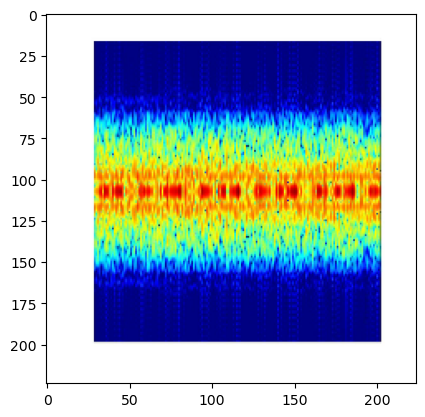

In [17]:
plt.imshow(X_resized[0])
plt.show()

In [21]:
# Encoding labels into numerical values and converting to categorical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
categorical_labels = to_categorical(encoded_labels, num_classes)

In [22]:
# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resized, categorical_labels, test_size=0.1, shuffle=True, random_state=42, stratify=categorical_labels)

In [23]:
# splitting of training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, shuffle=True, stratify=y_train)

#size of dataset
print(f"Training set size: {X_train.shape}, Training labels size: {y_train.shape}")
print(f"Validation set size: {X_val.shape}, Validation labels size: {y_val.shape}")
print(f"Testing set size: {X_test.shape}, Testing labels size: {y_test.shape}")

Training set size: (4145, 224, 224, 3), Training labels size: (4145, 6)
Validation set size: (219, 224, 224, 3), Validation labels size: (219, 6)
Testing set size: (485, 224, 224, 3), Testing labels size: (485, 6)


In [33]:
# data augmentation 
datagen = ImageDataGenerator(
    zoom_range = 0.2, # adds pixels
    brightness_range = [0.8, 1.2], # increasing intensity
    horizontal_flip = True, # random horizontal flipping
    rotation_range=10, # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1, # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.1,
    shear_range=0.15,
    fill_mode = 'nearest' # fill newly created pixels
)

In [34]:
datagen.fit(X_train)

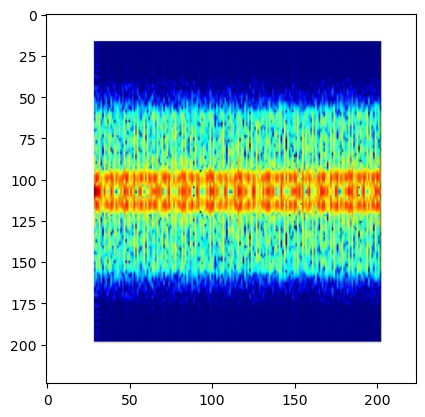

In [35]:
plt.imshow(X_train[0])
plt.show()

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_model(base_model):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(6, activation='softmax')
    ])
    return model

# Create VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg16_base.layers[:9]:
    layer.trainable = False
model_vgg16 = create_model(vgg16_base)

# Create VGG19 model
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg19_base.layers[:14]:
    layer.trainable = False
model_vgg19 = create_model(vgg19_base)

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss
    factor=0.5,            # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,           # Lower bound on the learning rate
    verbose=1              # Verbosity mode, 1: prints a message when reducing the learning rate
)

# Compile the models
def compile_model(model):
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

compile_model(model_vgg16)
compile_model(model_vgg19)

# Callbacks for early stopping and saving the best model
checkpoint_vgg16 = ModelCheckpoint("best_model_vgg16.keras", save_best_only=True, monitor='val_accuracy', mode='max')
checkpoint_vgg19 = ModelCheckpoint("best_model_vgg19.keras", save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the VGG16 model
history_vgg16 = model_vgg16.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[checkpoint_vgg16, early_stopping, reduce_lr]
)

Epoch 1/50


c:\Users\incha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 25/130 ━━━━━━━━━━━━━━━━━━━━ 17:46 10s/step - accuracy: 0.1647 - loss: 1.8281

KeyboardInterrupt: 

In [ ]:
# Train the VGG19 model
history_vgg19 = model_vgg19.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[checkpoint_vgg19, early_stopping, reduce_lr]
)

In [ ]:
test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(X_test, y_test)
test_loss_vgg19, test_accuracy_vgg19 = model_vgg19.evaluate(X_test, y_test)

print(f"VGG16 Test Accuracy: {test_accuracy_vgg16*100:.2f}%")
print(f"VGG19 Test Accuracy: {test_accuracy_vgg19*100:.2f}%")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# defining a deeper model
model = Sequential([
    InputLayer(input_shape=(224, 224, 3)),

    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    ReLU(),
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2), strides=2),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    ReLU(),
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2), strides=2),

    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    ReLU(),
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2), strides=2),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    ReLU(),
    Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2), strides=2),

    GlobalAveragePooling2D(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

In [ ]:
# callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

In [ ]:
batch_size = 40
steps_per_epoch = 4375 // batch_size  # Number of steps per epoch
validation_steps = 96 // batch_size  # Number of validation steps

In [ ]:
import time
start_time = time.time()
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=1000, # because we use early stopping
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]
)
end_time = time.time()

In [ ]:
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate on validation set (our test set)
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")